In [4]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

In [5]:
opti=asb.Opti(cache_filename="soln1.json")


### Constants
# World
g = 9.81  # [m/s^2]
e = 0.7  # Oswald efficiency factor standard for A320

# Structural
mass = 63000  # [kg]
weight = mass * g
weight_fuselage = 20000 * g  # [N] assumed fuselage weight
W_W_coeff1 = 7e-6  # Wing Weight Coefficient 1 [1/m]
W_W_coeff2 = 45.24  # Wing Weight Coefficient 2 [Pa]
ultimate_load_factor = 3.8  # ultimate load factor [-]
airfoil_thickness_fraction = 0.12  # Approx. for SC(2)-0412

# Propulsion
engine_thrust = 105000  # [N]
engine_tsfc = 0.0035  # [kg/m]

# Operating conditions
cruise_alt = 11000  # [m]
service_ceil = 13100  # [m]
atm = asb.atmosphere.Atmosphere(cruise_alt)
cruise_mach = 0.8  # [mach]
cruise_speed = atm.speed_of_sound() * cruise_mach


### Variables
# Main wing
wing_airfoil = asb.Airfoil("sc20412")
span = opti.variable(init_guess=45, lower_bound=35, upper_bound=50, scale=5)
chord_root = opti.variable(init_guess=3, lower_bound=1, upper_bound=15)
chord_tip = opti.variable(init_guess=1, lower_bound=.5, upper_bound=2)

# Truss wing
truss_span = span / 5
truss_chord_root = 1
truss_chord_tip = 0.5

# Stabs
stab_airfoil = asb.Airfoil("naca0012")
# aoa = opti.variable(init_guess=2, lower_bound=0, upper_bound=10, scale=1)


### Geoemtries
# Main wing
main_wing = asb.Wing(
    name="Main Wing",
    symmetric=True,  # Should this wing be mirrored across the XZ plane?
    xsecs=[  # The wing's cross ("X") sections
        asb.WingXSec(  # Root
            xyz_le=[
                0,
                0,
                1.5,
            ],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
            chord=chord_root,
            # twist=aoa,  # degrees
            airfoil=wing_airfoil  # Airfoils are blended between a given XSec and the next one.
        ),
        asb.WingXSec(  # Tip
            xyz_le=[
                np.sind(20) * (span/2),
                span / 2,
                1.5,
            ],
            chord=chord_tip,  # Tip chord is 20% of root chord
            # twist=aoa,
            airfoil=wing_airfoil
        ),
    ],
)
# Truss wing
truss_wing = asb.Wing(
    name="Wing Truss",
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[
                5, 
                0, 
                -1.5
            ],  # Truss connects to fuselage near root
            chord=truss_chord_root,
            airfoil=wing_airfoil,
        ),
        asb.WingXSec(
            xyz_le=[
                4,  # A bit inward from wing tip
                truss_span,
                -0.1 + 1.5 # Slight vertical offset to angle the truss
            ],
            chord=truss_chord_tip,
            airfoil=wing_airfoil,
        ),
    ]
)
# Ampenage
horiz_stab = asb.Wing(
    name="Horizontal stab",
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[21.5, 0, 1.0],  # Approx. location at rear fuselage
            chord=2.75,            # Larger root chord
            airfoil=stab_airfoil,  # Typically symmetric airfoil like NACA 0012
        ),
        asb.WingXSec(
            xyz_le=[24, 5.5, 0.9],  # Apply sweep and slight dihedral
            chord=1.0,                        # Smaller tip chord
            airfoil=stab_airfoil,
        ),
    ]
)
vert_stab = asb.Wing(
    name="Vertical stab",
    symmetric=False,
    xsecs=[
        asb.WingXSec(
            xyz_le=[21, 0, 1.0],  # Root at rear-top of fuselage
            chord=4.0,
            airfoil=stab_airfoil,  # Typically symmetric (e.g., NACA 0012)
        ),
        asb.WingXSec(
            xyz_le=[24.5, 0, 7],  # Add sweep, go upward
            chord=1.5,
            airfoil=stab_airfoil,
        ),
    ]
)
# Engines
left_engine = asb.Propulsor(
    name="Left Engine",
    xyz_c=[1.5, -7, -0.5],  # Approx. underwing, side-mounted
    radius=1,
    length=3.5
)
right_engine = asb.Propulsor(
    name="Right Engine",
    xyz_c=[1.5, 7, -0.5],  # Approx. underwing, side-mounted
    radius=1,
    length=3.5
)
# Fuselage
asb.horizontal
asb.Fuselage()
fuselage = asb.Fuselage(
    name="ACE-1 Fuselage",
    symmetric=True,
    xsecs=[
        asb.FuselageXSec(
            xyz_c=[-13.04-0.196, 0, -0.444],
            radius=0
        ),
        asb.FuselageXSec(
            xyz_c=[-13.04, 0, -0.444],
            radius=0.63842502/2
        ),
        asb.FuselageXSec(
            xyz_c=[-12.74, 0, -0.444],
            radius=1.04048993/2
        ),
        asb.FuselageXSec(
            xyz_c=[-11.727, 0, -0.44427933],
            radius=0.9648
        ),
        asb.FuselageXSec(
            xyz_c=[-10.610, 0, -0.21648632],
            radius=2.95801910/2
        ),
        asb.FuselageXSec(
            xyz_c=[-9.464, 0, -0.13295889],
            radius=1.719
        ),
        asb.FuselageXSec(
            xyz_c=[-7.411, 0, 0],
            radius=1.89
        ),
        asb.FuselageXSec(
            xyz_c=[-6.248, 0, 0],
            radius=1.88           # Constant diameter midsection
        ),
        asb.FuselageXSec(
            xyz_c=[11.25174427, 0, 0],
            radius=1.88           # Constant diameter midsection
        ),
        asb.FuselageXSec(
            xyz_c=[13.3389, 0, 0.0377],
            radius=1.858
        ),
        asb.FuselageXSec(
            xyz_c=[16.1137, 0, 0.20096818],
            radius=1.67718
        ),
        asb.FuselageXSec(
            xyz_c=[18.9266, 0, 0.48167075],
            radius=1.35949
        ),
        asb.FuselageXSec(
            xyz_c=[21.72, 0, 0.90215062],
            radius=0.9021
        ),
        asb.FuselageXSec(
            xyz_c=[26.0569, 0, 1.31256010],
            radius=0.471701
        ),
        asb.FuselageXSec(
            xyz_c=[26.25, 0, 1.31256010],
            radius=0
        )
    ]
)


# Wing weight model
weight_wing_structural = W_W_coeff1 * (
        ultimate_load_factor * main_wing.aspect_ratio() ** 1.5 *
        (weight_fuselage * weight * main_wing.area()) ** 0.5
) / airfoil_thickness_fraction
weight_wing_surface = W_W_coeff2 * main_wing.area()
weight_wing = weight_wing_surface + weight_wing_structural


airplane = asb.Airplane(
    name="ACE-1",
    xyz_ref=[0.25 * chord_root, 0, 0],  # CG location
    wings=[main_wing, truss_wing, horiz_stab, vert_stab],
    fuselages=[fuselage],
    propulsors=[left_engine, right_engine]
)


### Aerodynamics
vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=cruise_speed,
        # alpha=5,
    )
)
abu = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=cruise_speed,
        # alpha=5,
    )
)
aero_vlm = vlm.run()
aero_abu = abu.run()

D_induced_vlm = aero_vlm["D"]
D_parasitic_abu = aero_abu["D_profile"]  # Already includes drag from all modeled components
D_total_hybrid = D_induced_vlm + D_parasitic_abu
L_vlm = aero_vlm["L"]  # More accurate lift


### Weight model
weight_wing_structural = W_W_coeff1 * (
        ultimate_load_factor * main_wing.aspect_ratio() ** 1.5 *
        (weight_fuselage * weight * main_wing.area()) ** 0.5
) / airfoil_thickness_fraction
weight_wing_surface = W_W_coeff2 * main_wing.area()
weight_wing = weight_wing_surface + weight_wing_structural


### Constraints and objective
opti.subject_to([
    L_vlm == weight + weight_wing
])
opti.minimize(D_total_hybrid)

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4869839e+04 1.17e+04 1.98e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [6]:
# Output results
sol_main_wing = sol(main_wing)
sol_span = sol(span)
sol_chord_root = sol(chord_root)
sol_chord_tip = sol(chord_tip)

sol_truss_wing = sol(truss_wing)
sol_truss_span = sol_span / 5

sol_lift_vlm = sol(L_vlm)
sol_aero_vlm = sol(aero_vlm)
sol_aero_abu = sol(aero_abu)

# Aircraft dimensions
print("---AIRCRAFT DIMENSIONS---")
print("Reference wing area (m^2):", sol_main_wing.area())
print("")
print("-MAIN WING-")
print("Wingspan (m):", sol_span)
print("Chord Root Length (m):", sol_chord_root)
print("Chord Tip Length (m):", sol_chord_tip)
print(f"Aspect Ratio: {sol_span**2 / sol_main_wing.area():.2f}")
print("Wetted area (m^2):", sol_main_wing.area(type="wetted"))
print("")
print("-STRUT WING-")
print("Wingspan (m):", sol_span / 5)
print("Chord Root Length (m):", truss_chord_root)
print("Chord Tip Length (m):", truss_chord_tip)
print("Wetted area (m^2):", sol_truss_wing.area(type="wetted"))
print("")

# Aerodynamics
print("---AIRCRAFT DIMENSIONS---")
print("Lift [kg]:", sol_lift_vlm / g)
print("Induced Drag (VLM):", sol_aero_vlm["D"])
print("Parasitic Drag Coefficient (AeroBuildup):", sol_aero_abu["CD"])  # Already includes drag from all modeled components)
print("Parasitic Drag (AeroBuildup):", sol_aero_abu["D_profile"])
print("Hybrid Drag [N]:", sol(D_total_hybrid))

---AIRCRAFT DIMENSIONS---
Reference wing area (m^2): 92.09478244290476

-MAIN WING-
Wingspan (m): 42.3994568551242
Chord Root Length (m): 3.844149170093
Chord Tip Length (m): 0.4999999900052441
Aspect Ratio: 19.52
Wetted area (m^2): 188.18132589358711

-STRUT WING-
Wingspan (m): 8.47989137102484
Chord Root Length (m): 1
Chord Tip Length (m): 0.5
Wetted area (m^2): 27.46886452315845

---AIRCRAFT DIMENSIONS---
Lift [kg]: 69936.96299386515
Induced Drag (VLM): 1759.3704637339429
Parasitic Drag Coefficient (AeroBuildup): 0.019795746153487042
Parasitic Drag (AeroBuildup): 53054.843383764164
Hybrid Drag [N]: 54814.213847498104


In [7]:
### Lift-due-to-drag Hand Calcs
mu = sol_truss_span / sol_span
r = sol_truss_wing.area(type="wetted") / sol_main_wing.area(type="wetted")
sigma = 0.2
e = ((mu**2) * (1+r)**2) / ((mu**2) + 2*sigma*mu*r + r**2)

print("mu:", mu)
print("Oswald efficiency estimate Biplane Interference:", e)

mu: 0.19999999999999998
Oswald efficiency estimate Biplane Interference: 0.7197365227730277


c:\Users\Asolg\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


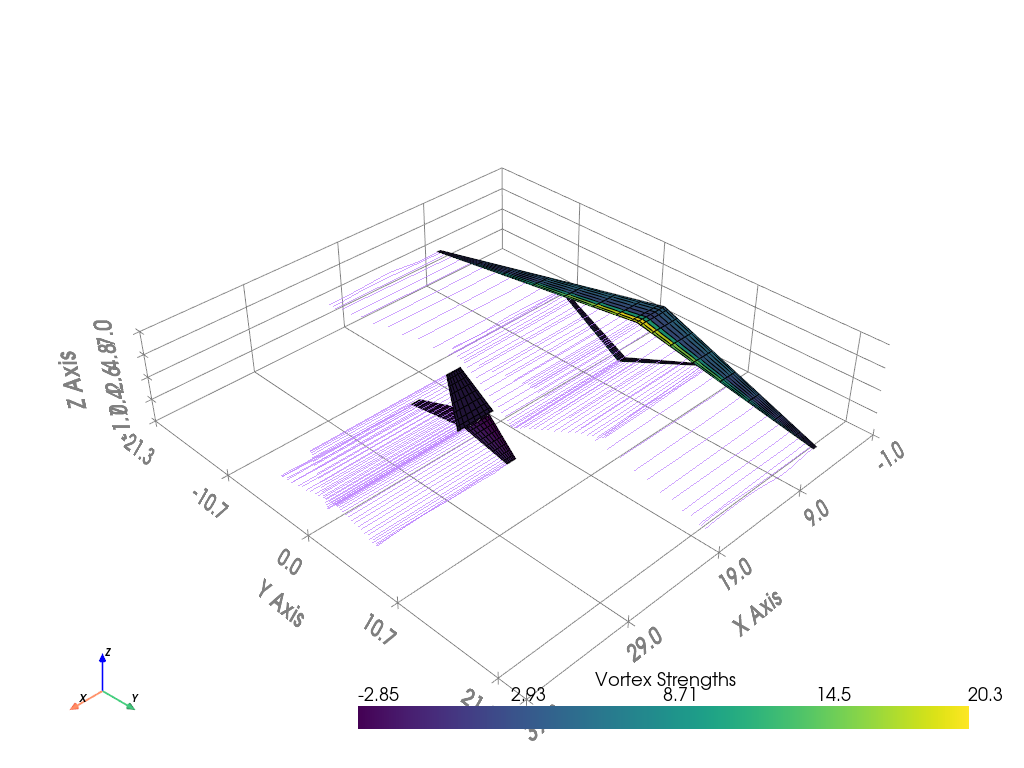

c:\Users\Asolg\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


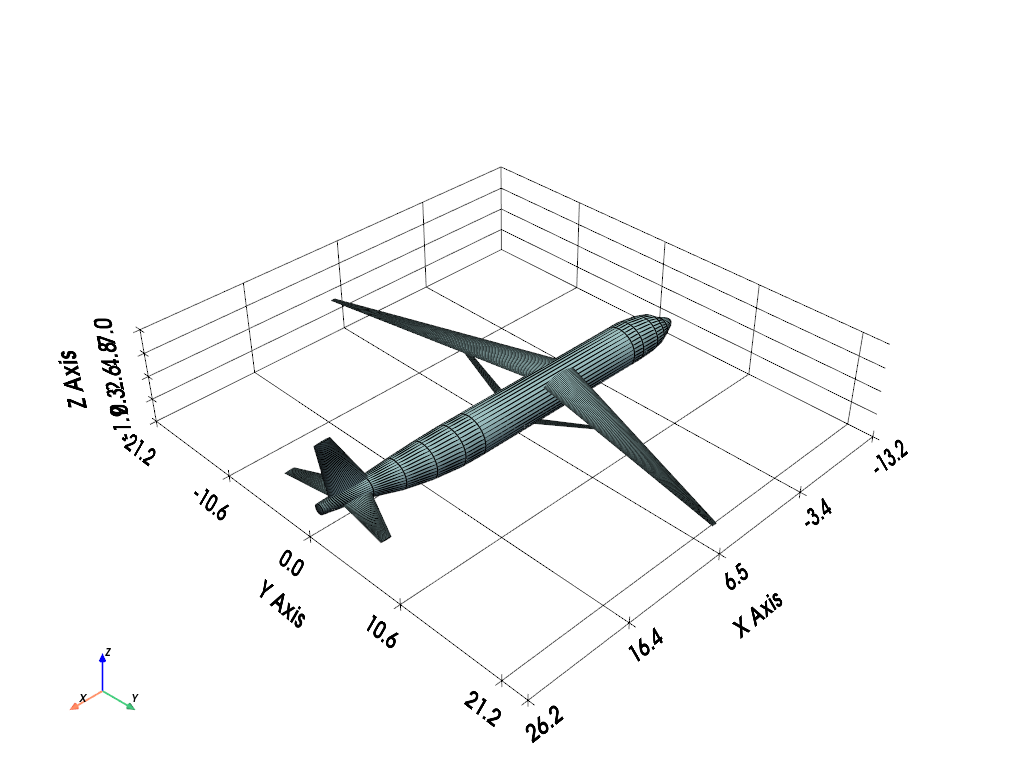

PolyData,Information
N Cells,1519
N Points,1562
N Strips,0
X Bounds,"-1.324e+01, 2.625e+01"
Y Bounds,"-2.120e+01, 2.120e+01"
Z Bounds,"-1.890e+00, 7.000e+00"
N Arrays,0


In [8]:
vlm=sol(vlm)
vlm.draw()
airplane=sol(airplane)
airplane.draw()

C_L_alpha, Lift curve slope: 0.13852955065695016
Drag 0.01961444621614457
Drag Force 21454.137736820485


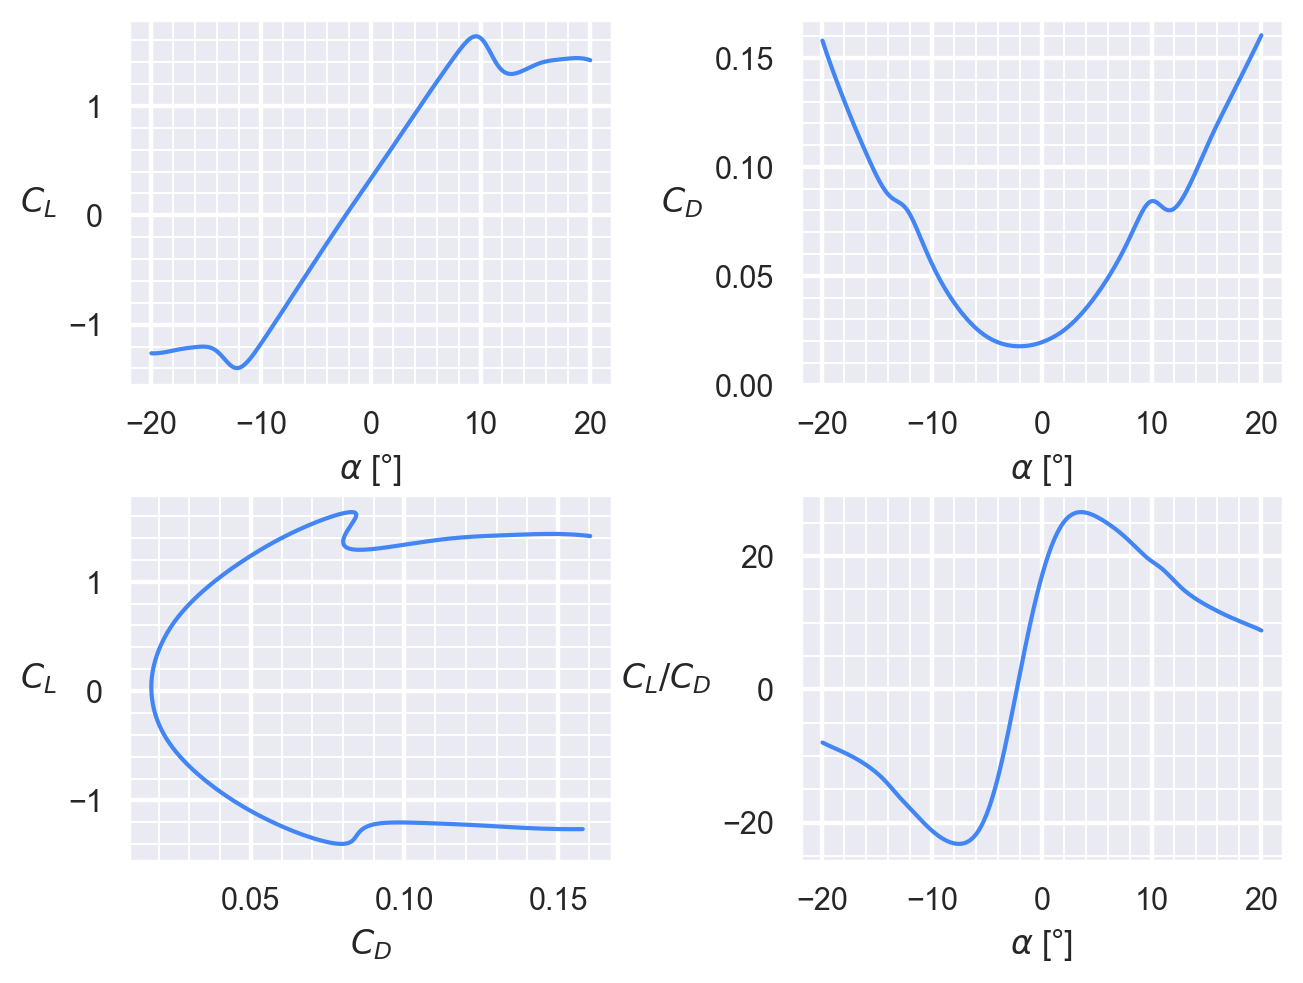

In [9]:
# Plotting
alpha = np.linspace(-20, 20, 300)

ps3_mach = 0.5  # [mach]
ps3_speed = atm.speed_of_sound() * ps3_mach

aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=ps3_speed,
        alpha=alpha,
        beta=0
    ),
).run()

fig, ax = plt.subplots(2, 2)

cl = aero["CL"]
lift_curve_slope = (cl[225]-cl[75])/(alpha[225]-alpha[75])
print("C_L_alpha, Lift curve slope:", lift_curve_slope)
print("Drag", aero["CD"][150])
print("Drag Force", aero["D_profile"][150])


plt.sca(ax[0, 0])
plt.plot(alpha, aero["CL"])
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$C_L$")
p.set_ticks(5, 1, 0.5, 0.1)

plt.sca(ax[0, 1])
plt.plot(alpha, aero["CD"])
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$C_D$")
p.set_ticks(5, 1, 0.05, 0.01)
plt.ylim(bottom=0)

plt.sca(ax[1, 0])
plt.plot(aero["CD"], aero["CL"])
plt.xlabel(r"$C_D$")
plt.ylabel(r"$C_L$")
p.set_ticks(5, 1, 0.5, 0.1)

plt.sca(ax[1, 1])
plt.plot(alpha, aero["CL"] / aero["CD"])
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$C_L/C_D$")
p.set_ticks(5, 1, 10, 2)

p.show_plot()

c:\Users\Asolg\AppData\Local\Programs\Python\Python310\lib\site-packages\aerosandbox\aerodynamics\aero_3D\aero_buildup.py:739: RuntimeWarning: invalid value encountered in divide
  vel_dir_g = [vel_vector_g[i] / vel_mag_g for i in range(3)]
c:\Users\Asolg\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralfoil\main.py:171: RuntimeWarning: divide by zero encountered in log
  (np.log(Re) - 12.5) / 3.5,
c:\Users\Asolg\AppData\Local\Programs\Python\Python310\lib\site-packages\aerosandbox\numpy\surrogate_model_tools.py:250: RuntimeWarning: invalid value encountered in divide
  return x / (1 + _np.exp(-beta * x))
c:\Users\Asolg\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralfoil\main.py:227: RuntimeWarning: invalid value encountered in matmul
  x = w @ x + np.reshape(b, (-1, 1))
c:\Users\Asolg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis

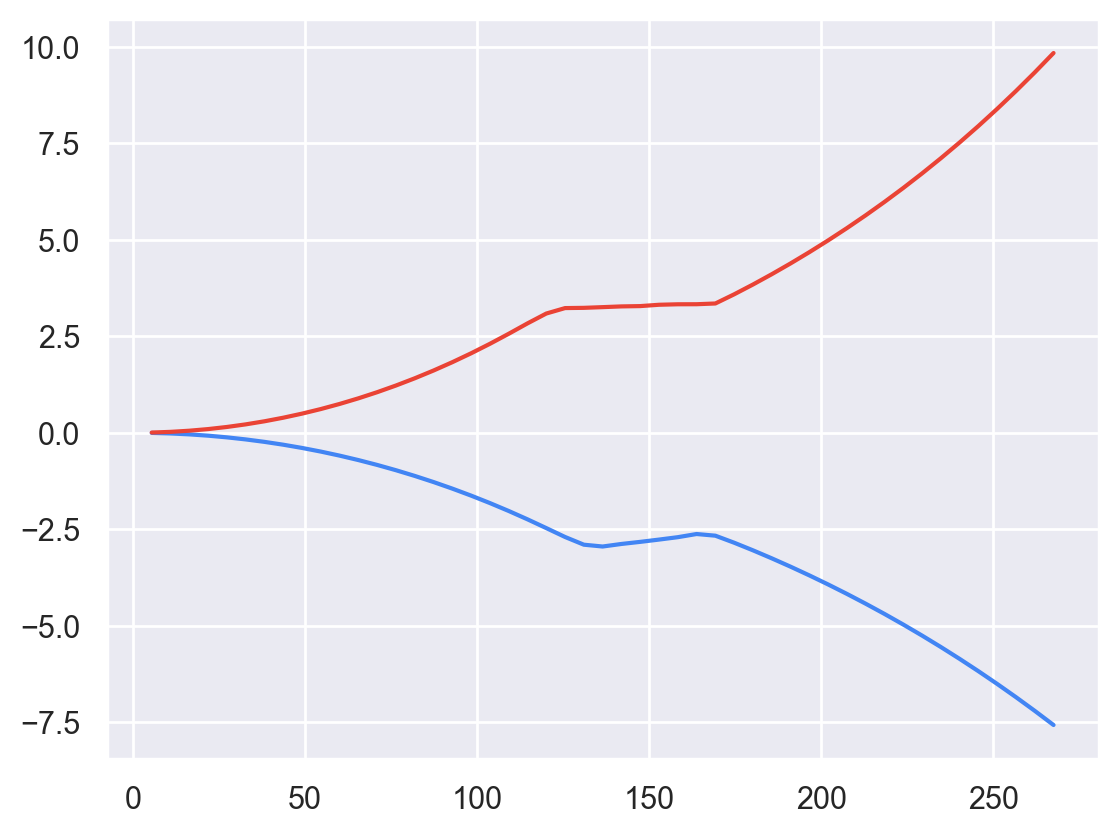

In [52]:
import pandas as pd
# Calculate CL_max at different cruise speeds
max_speed = atm.speed_of_sound() * .9
speeds = np.linspace(0, max_speed, 50)  # Range of speeds in m/s
lift_mins = []
lift_maxes = []
min_alpha = -15
max_alpha = 15
alpha = np.linspace(min_alpha, max_alpha, 50)

for speed in speeds:
    # Calculate aerodynamics at each speed
    speed_aero = asb.AeroBuildup(
        airplane=airplane,
        op_point=asb.OperatingPoint(
            velocity=speed,
            alpha=alpha,
            beta=0
        ),
    ).run()
    # Normalize by weight
    lift_maxes.append(np.max(speed_aero["L"]) / weight)
    lift_mins.append(np.min(speed_aero["L"]) / weight)

# Plot CL_max vs cruise speed
plt.figure()
plt.plot(speeds, lift_mins)
plt.plot(speeds, lift_maxes)
plt.grid(True)
plt.show()

# Export CL vs speed data to CSV
data = {
    'Speed (m/s)': speeds,
    'Lift_min': lift_mins,
    'Lift_max': lift_maxes
}
df = pd.DataFrame(data)
df.to_csv('lift_vs_speed.csv', index=False)




18


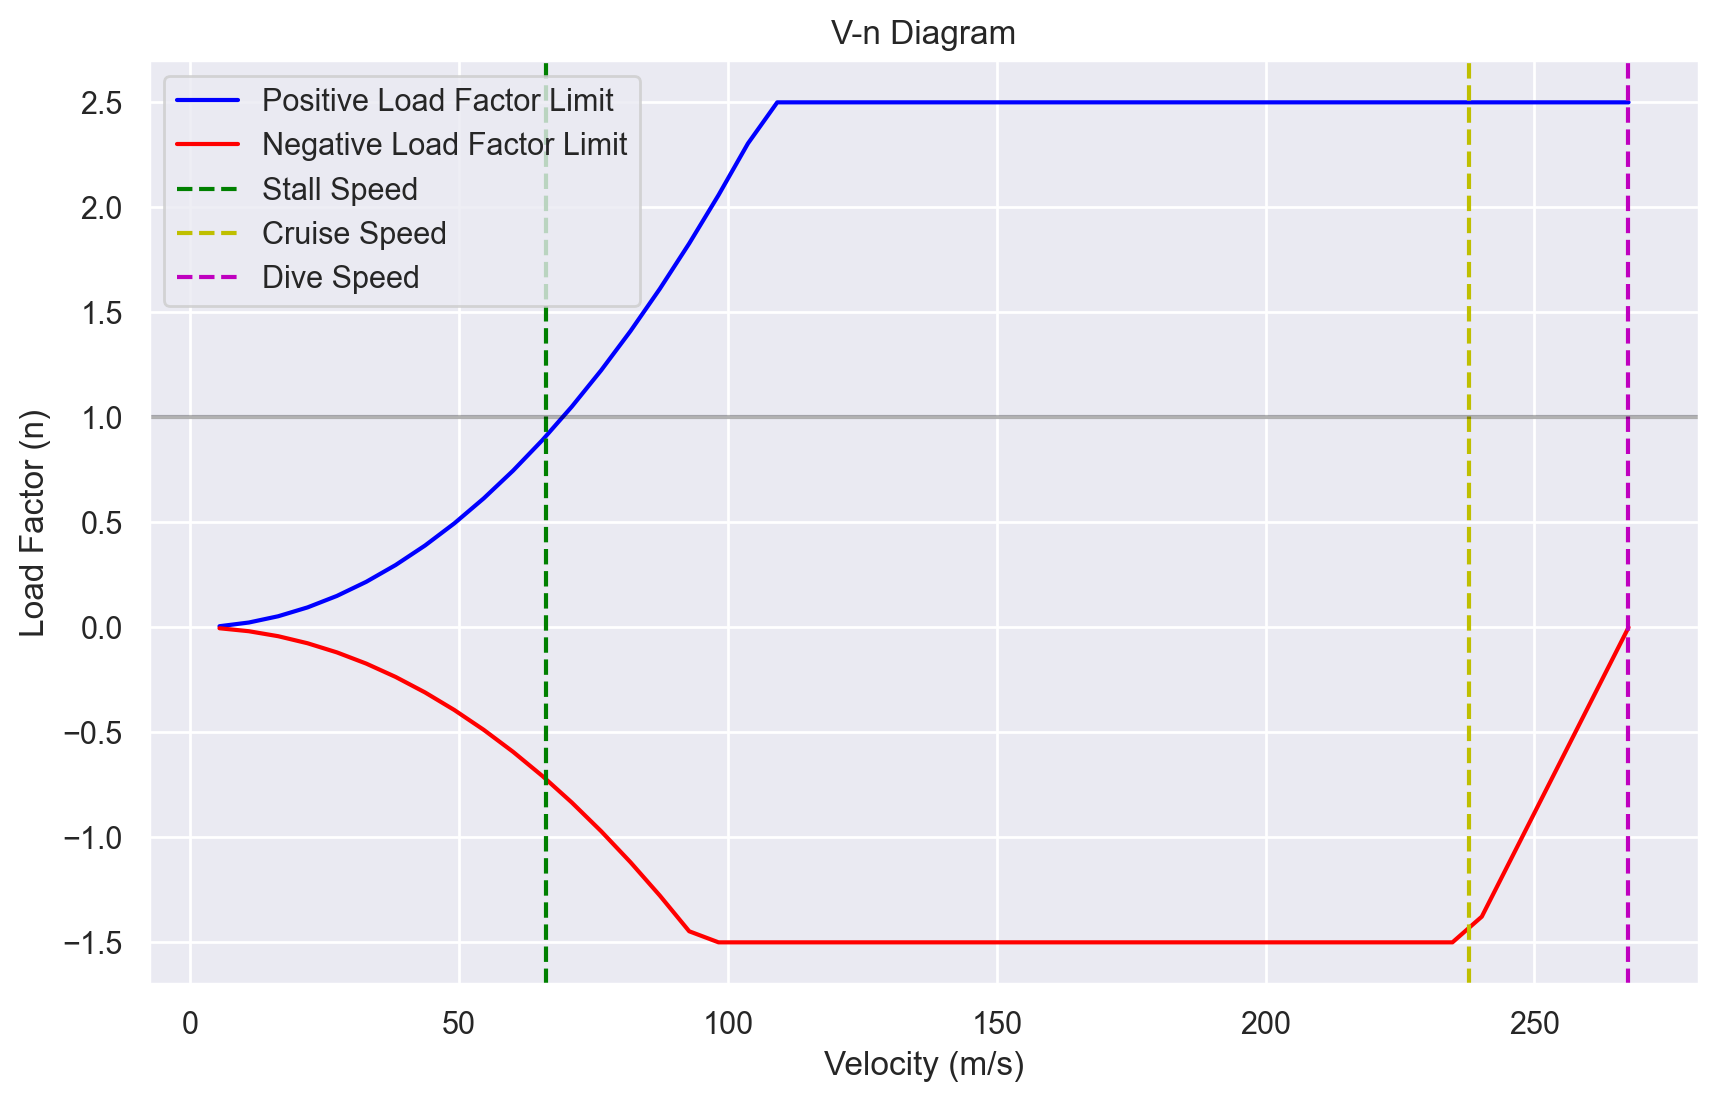

In [53]:
# Set the maximum load factors
n_pos = 2.5
n_neg = -1.5

v_dive = 267.4 # m/s, Mach 0.9, 36089.24 ft, just an educated guess
sea_level_density = 1.225 # kg/m^3
v_stall = np.sqrt(2 * weight / (sea_level_density * sol(main_wing).area() * n_pos))

# Convert the lift_maxes and lift_mins to load factors
lift_maxes = np.array(lift_maxes)
lift_mins = np.array(lift_mins)


# Cut off the data for cl_max at it's maximum value
for i in range(len(lift_maxes)):
    if lift_maxes[i] > n_pos:
        max_lift_index = i
        break
# Cap the data at the max cl value
for i in range(max_lift_index, len(lift_maxes)):
    lift_maxes[i] = n_pos

# Cut off the data for min lift at n_neg
for i in range(len(lift_mins)):
    if lift_mins[i] < n_neg:
        min_lift_index = i
        break
print(min_lift_index)
# Cap the data at the min cl value
for i in range(min_lift_index, len(lift_mins)):
    lift_mins[i] = n_neg

# Find the index of the the velocity that is closest to v_cruise and v_dive
v_cruise_index = np.argmin(np.abs(speeds - cruise_speed))
v_dive_index = np.argmin(np.abs(speeds - v_dive))

# Create the line from min load to 0 at dive speed
intercept = lift_mins[v_cruise_index]
slope = (0 - intercept) / (speeds[-1] - cruise_speed)
for i in range(v_cruise_index, len(speeds)):
    lift_mins[i] = intercept + slope * (speeds[i] - cruise_speed)

# Plot V-n diagram
plt.figure(figsize=(10, 6))
plt.plot(speeds, lift_maxes, 'b-', label='Positive Load Factor Limit')
plt.plot(speeds, lift_mins, 'r-', label='Negative Load Factor Limit')

# Add vertical lines for key velocities
plt.axvline(x=v_stall, color='g', linestyle='--', label='V_stall')
plt.axvline(x=cruise_speed, color='y', linestyle='--', label='V_cruise')
plt.axvline(x=v_dive, color='m', linestyle='--', label='V_dive')

# Add horizontal line at n=1 (level flight)
plt.axhline(y=1, color='k', linestyle='-', alpha=0.3)

plt.xlabel('Velocity (m/s)')
plt.ylabel('Load Factor (n)')
plt.title('V-n Diagram')
plt.legend()
plt.show()

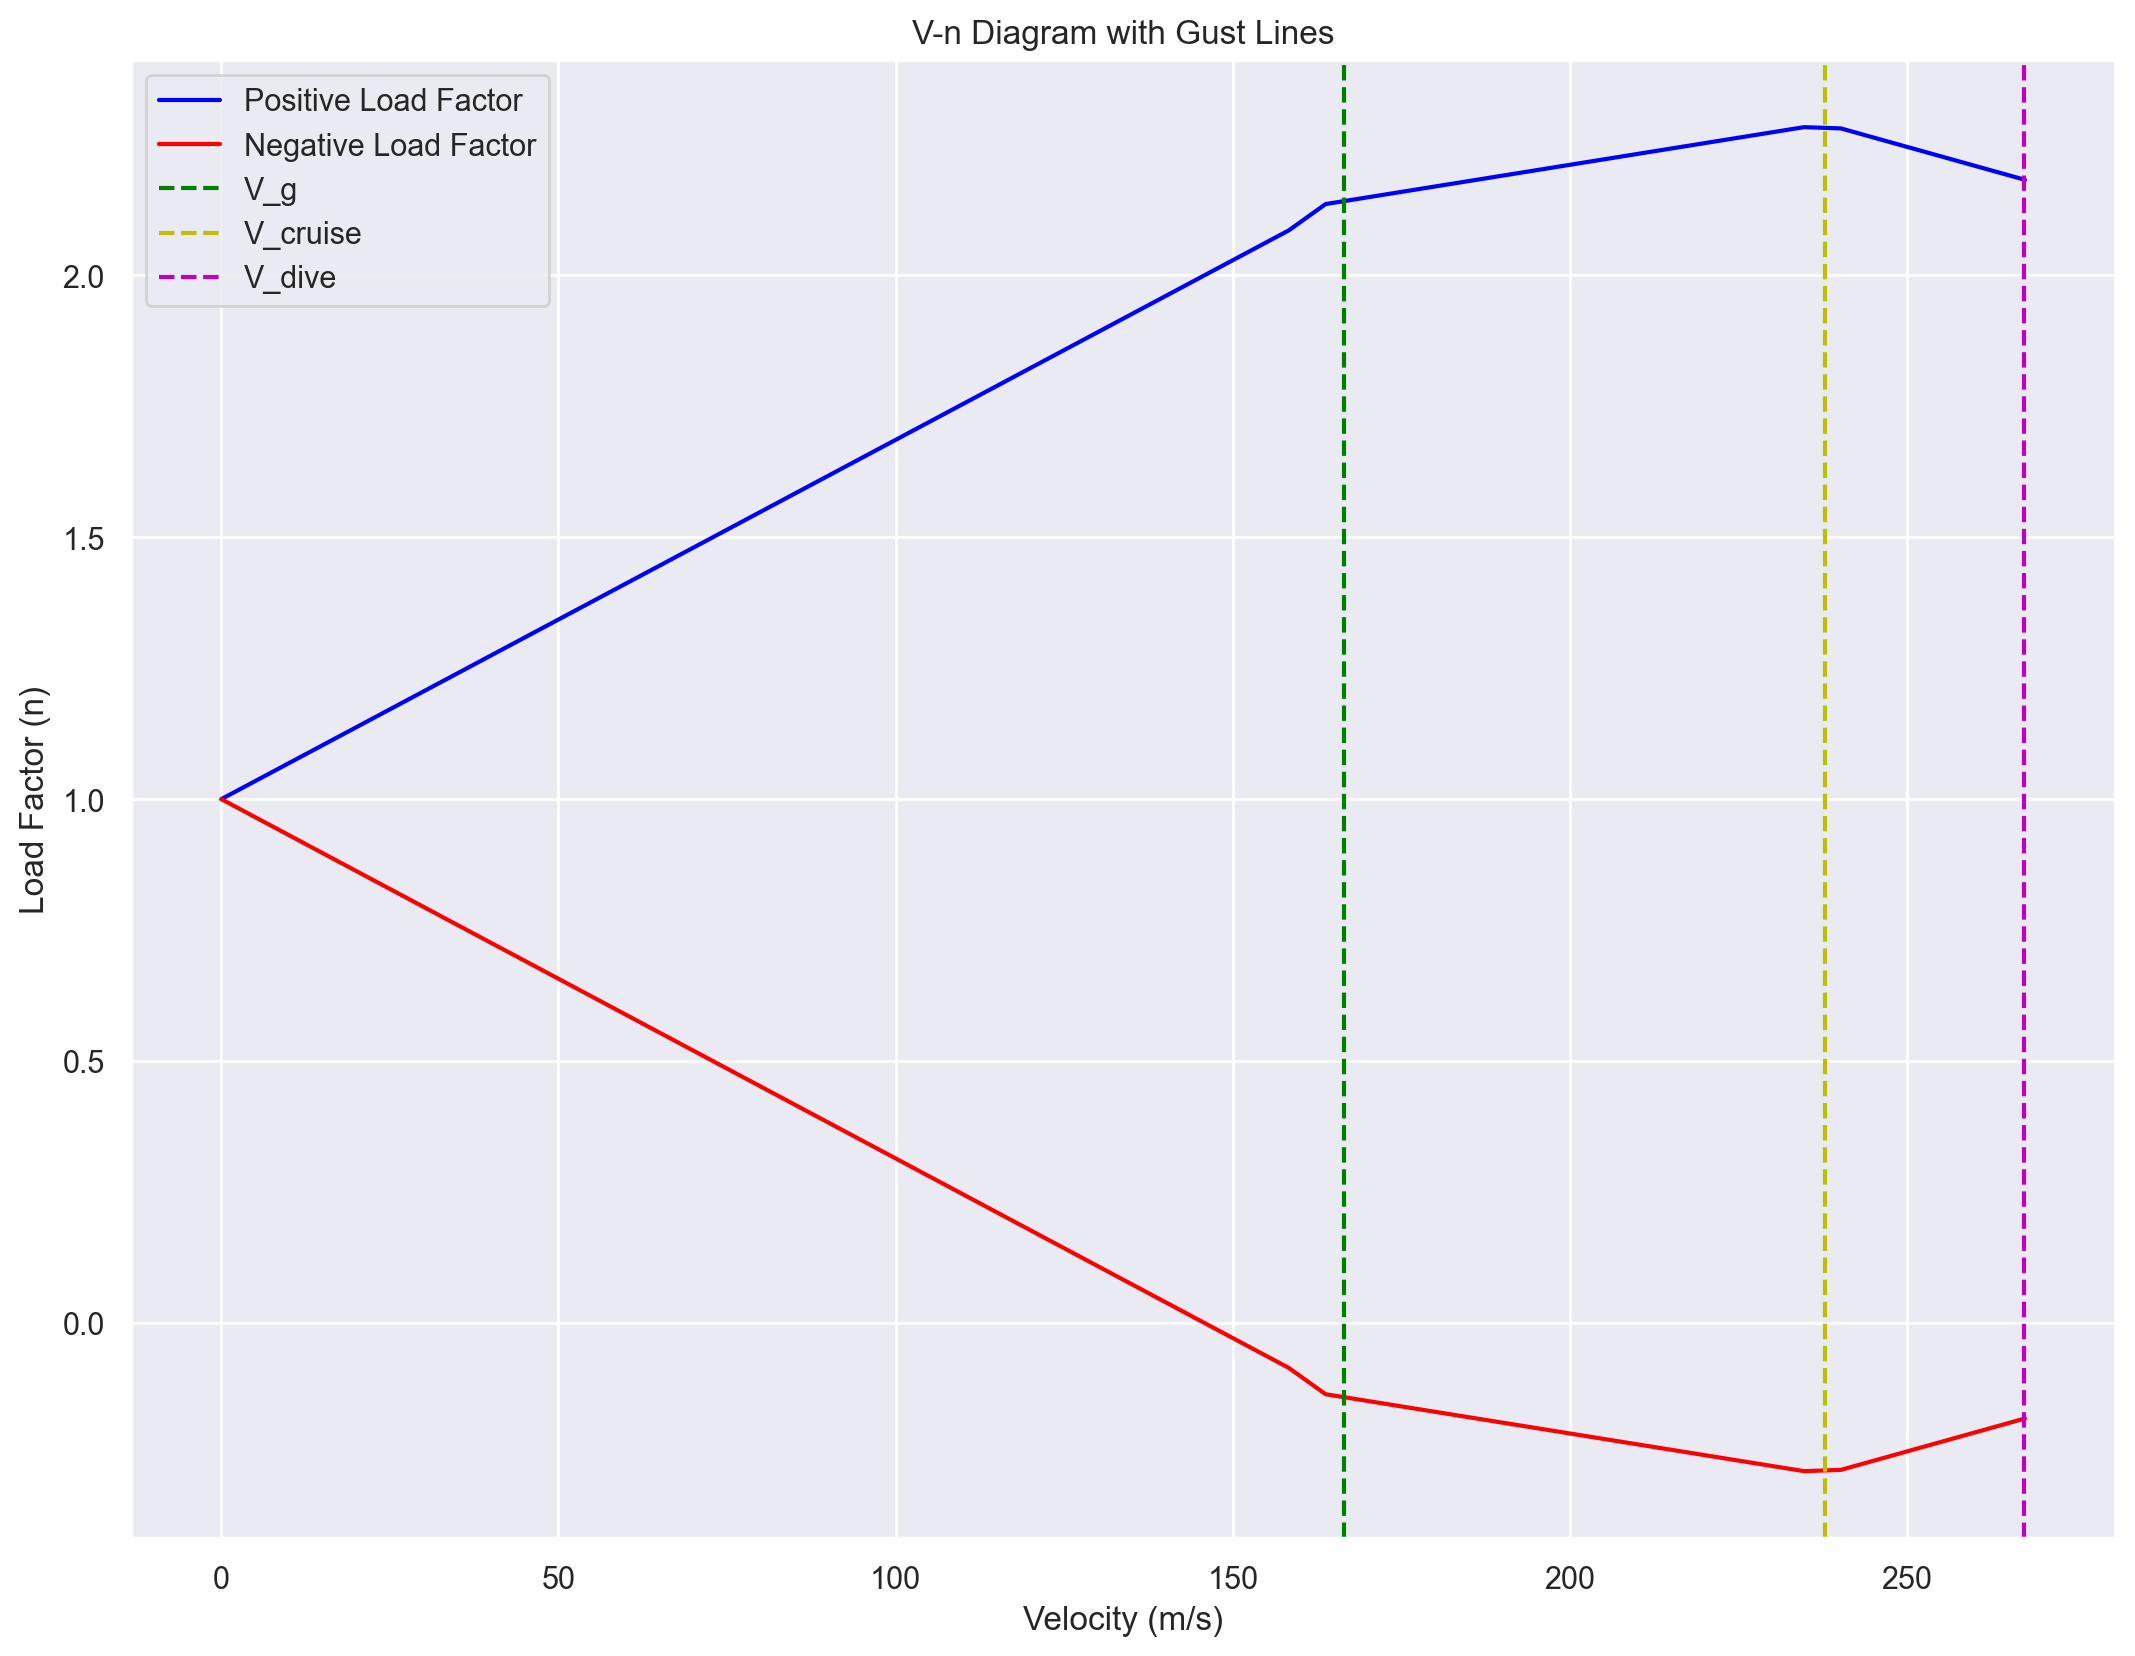

In [ ]:
# Calculate the mass ratio of the aircraft
lift_curve_slope = 4
mass_ratio = (2 * weight) / (sea_level_density * sol(main_wing).area()
                              * ((sol_chord_root + sol_chord_tip) / 2) * lift_curve_slope)
K = (0.88 * mass_ratio) / (5.3 + mass_ratio)

v_g = 0.7 * cruise_speed
gust_speed = 9.1 # m/s
delta_alpha = K * gust_speed / v_g
n_0 = 1

delta_lift_g = .5 * atm.density() * v_g**2 * sol(main_wing).area() * lift_curve_slope * delta_alpha
delta_lift_cruise = .5 * atm.density() * cruise_speed**2 * sol(main_wing).area() * lift_curve_slope * delta_alpha
# The /2 is to account for a 15mph gust, which halves delta_alpha
delta_lift_final = .5 * atm.density() * (v_dive)**2 * sol(main_wing).area() * lift_curve_slope * (delta_alpha / 2)

n_max_gust = n_0 + (weight + delta_lift_g) / weight # After normalizing by weight
n_max_cruise = n_0 + (weight + delta_lift_cruise) / weight # After normalizing by weight
n_max_final = n_0 + (weight + delta_lift_final) / weight # After normalizing by weight

index_vg = np.argmin(np.abs(speeds - v_g))
index_cruise = np.argmin(np.abs(speeds - cruise_speed))
index_final = np.argmin(np.abs(speeds - v_dive))#speeds[len(speeds) - 1]


n_max = np.zeros(len(speeds))
n_min = np.zeros(len(speeds))

slope =  (n_max_gust - 1) / (v_g - 0)
for i in range(0, index_vg):
    n_max[i] = 1 + slope * (speeds[i])
    n_min[i] =  1 - (slope * speeds[i])

slope = (n_max_cruise - n_max_gust) / (cruise_speed - v_g)
for i in range(index_vg, index_cruise):
    n_max[i] = n_max_gust + slope * (speeds[i] - v_g)
    n_min[i] = (2-n_max_gust) - slope * (speeds[i] - v_g)

slope = (n_max_final - n_max_cruise) / (v_dive - cruise_speed)
for i in range(index_cruise, index_final + 1):
    n_max[i] = n_max_cruise + slope * (speeds[i] - cruise_speed)
    n_min[i] = (2-n_max_cruise) - slope * (speeds[i] - cruise_speed)

# Plot the V-n diagram
plt.figure(figsize=(12.8, 9.6))
plt.plot(speeds, n_max, 'b-', label='Positive Load Factor Limit')
plt.plot(speeds, n_min, 'r-', label='Negative Load Factor Limit')
plt.grid(True)
plt.axvline(x=v_g, color='g', linestyle='--', label='V_g')
plt.axvline(x=cruise_speed, color='y', linestyle='--', label='V_cruise')
plt.axvline(x=v_dive, color='m', linestyle='--', label='V_dive')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Load Factor (n)')
plt.title('V-n Diagram with Gust Lines')
plt.legend()


plt.show()



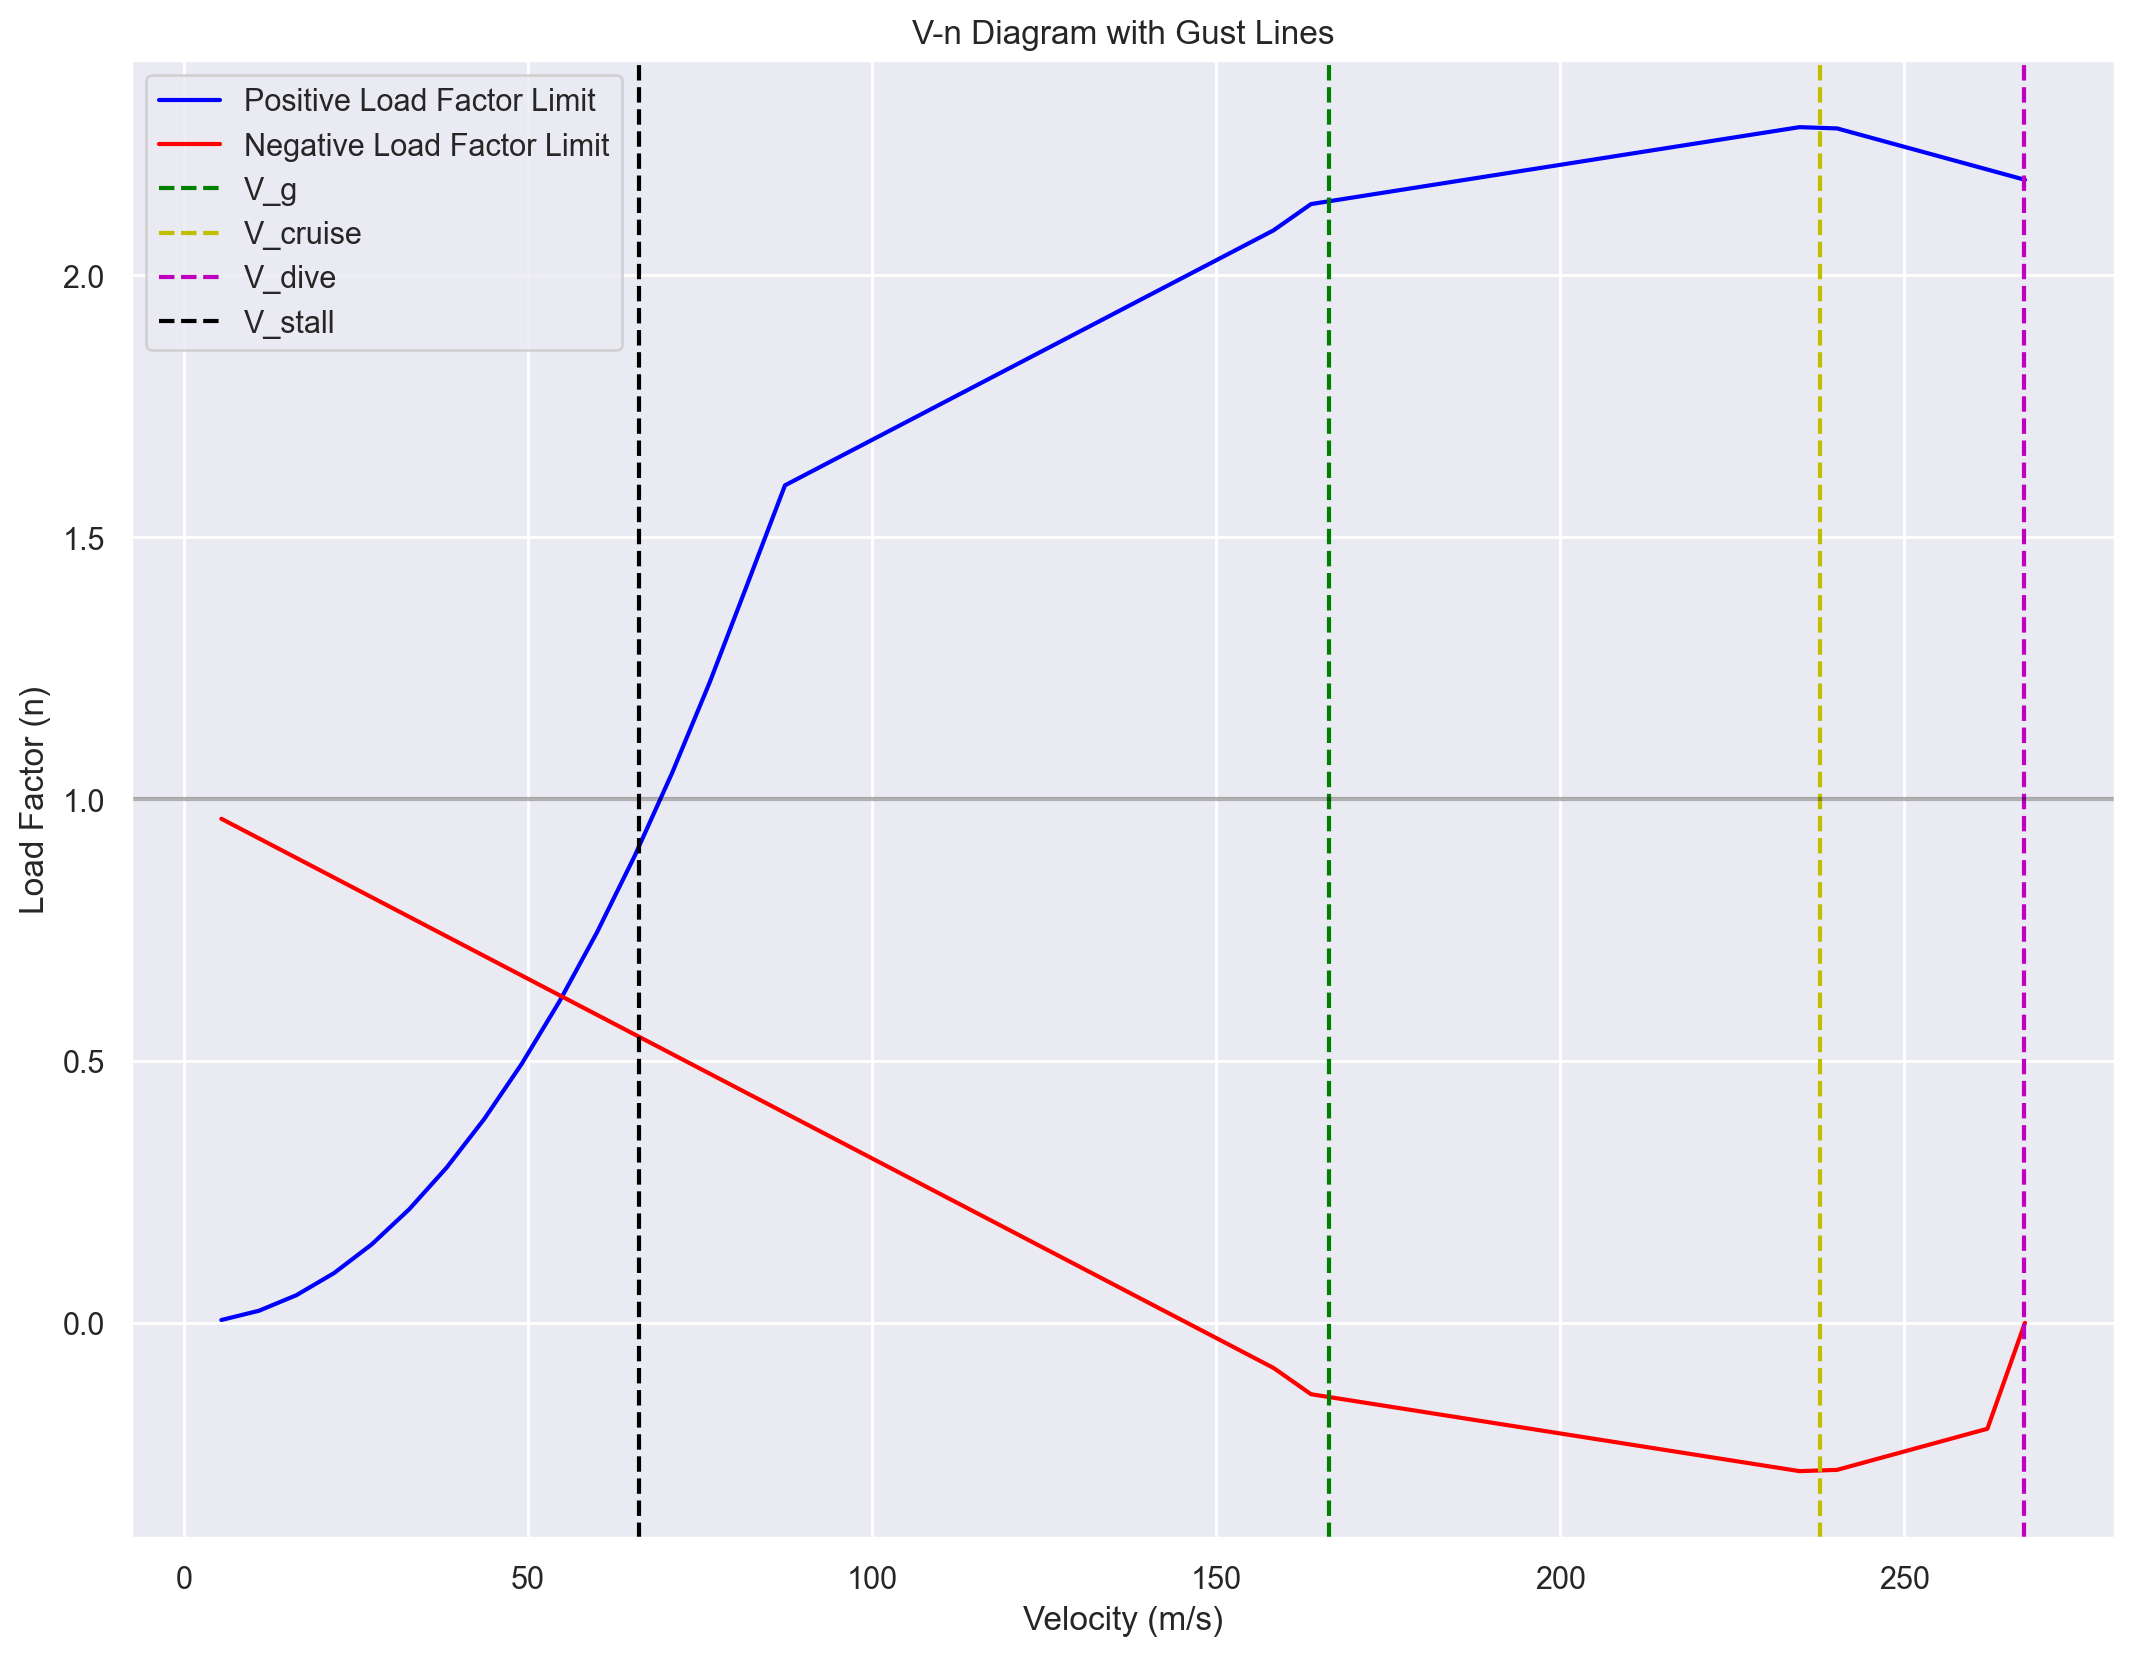

In [74]:
# Combine the limits of the V-n diagram with the gust lines
top_limit = np.minimum(lift_maxes, n_max)
bottom_limit = np.maximum(np.minimum(lift_mins,0), n_min)

plt.figure(figsize=(12.8, 9.6))
plt.plot(speeds, top_limit, 'b-', label='Positive Load Factor Limit')
plt.plot(speeds, bottom_limit, 'r-', label='Negative Load Factor Limit')
plt.grid(True)
plt.axvline(x=v_g, color='g', linestyle='--', label='V_g')  
plt.axvline(x=cruise_speed, color='y', linestyle='--', label='V_cruise')
plt.axvline(x=v_dive, color='m', linestyle='--', label='V_dive')
plt.axvline(x=v_stall, color='k', linestyle='--', label='V_stall')
plt.axhline(y=1, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Load Factor (n)')
plt.title('V-n Diagram with Gust Lines')
plt.legend()
plt.show()

Results at takeoff altitude: 2438.4 m
Speed of sound: 331.10956996702197 m/s
Density: 0.9610381423538694 kg/m^3
Maximum CL: 2.5608919622140984
CL at optimal angle of attack: 0.8640494185812188


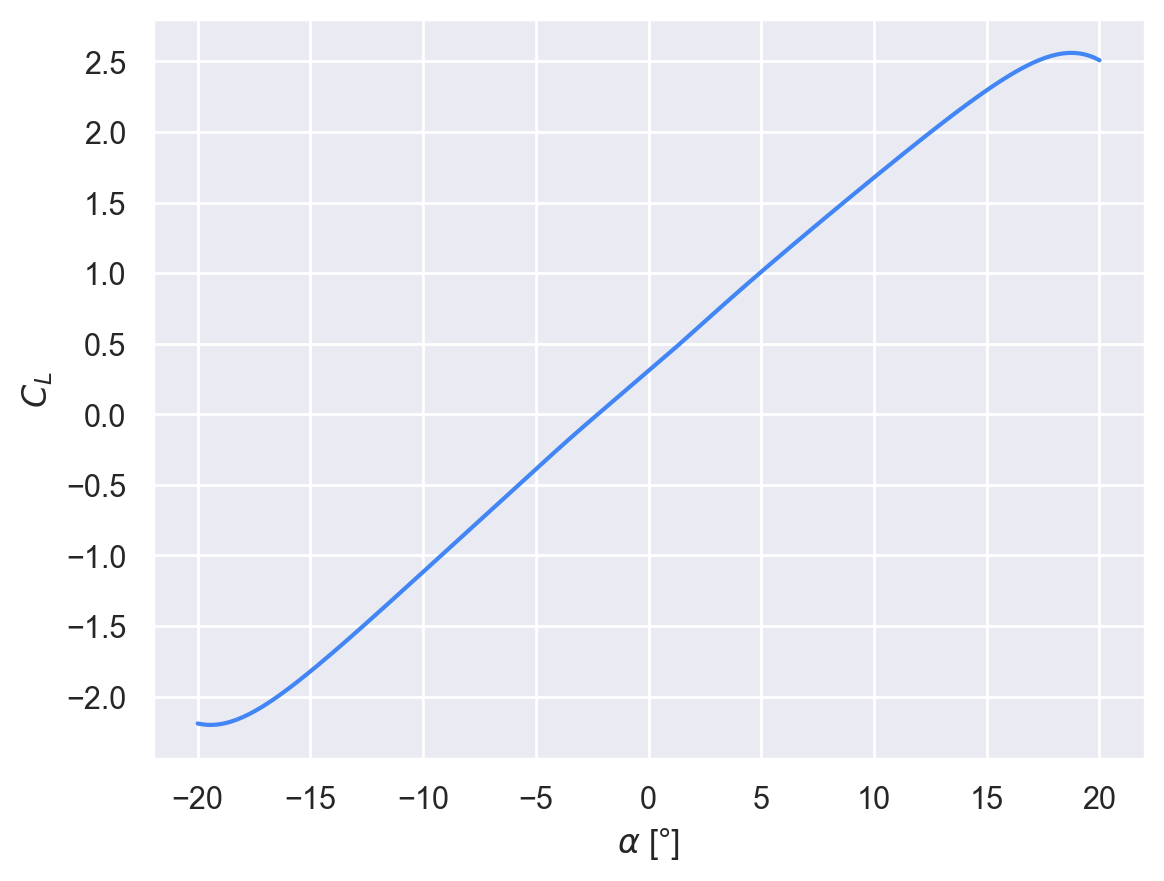

In [9]:
# Calculate CL at a takeoff altitude
takeoff_altitude = 2438.4  # [m] - example altitude
takeoff_atm = asb.atmosphere.Atmosphere(takeoff_altitude)
takeoff_speed = 77.16 # m/s

# Calculate aerodynamics at new altitude
takeoff_aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=takeoff_speed,
        alpha=alpha,
        beta=0
    ),
).run()

# Print results
print("Results at takeoff altitude:", takeoff_altitude, "m")
print("Speed of sound:", takeoff_atm.speed_of_sound(), "m/s")
print("Density:", takeoff_atm.density(), "kg/m^3")
print("Maximum CL:", np.max(takeoff_aero["CL"]))
print("CL at optimal angle of attack:", takeoff_aero["CL"][np.argmax(takeoff_aero["CL"] / takeoff_aero["CD"])])

# Plot alpha x CL
plt.clf()
plt.plot(alpha, takeoff_aero["CL"])
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$C_L$")
p.set_ticks(5, 1, 0.5, 0.1)
plt.show()

In [ ]:
# Filter alpha values greater than 0
cl_takeoff = 2 * weight / (takeoff_atm.density() * sol(main_wing).area() * takeoff_speed**2)
cl_max = takeoff_aero["CL"][225]
cl_delta = cl_takeoff - cl_max
print(takeoff_speed)

# Find the index of cl_max
cl_max_index = np.argmax(takeoff_aero["CL"])
alpha_at_cl_max = takeoff_aero["alpha"][cl_max_index]

print("Alpha at CL max:", alpha_at_cl_max)
print("CL Max (constrained):", cl_max)
print("CL Takeoff:", cl_takeoff)
print("CL Delta:", cl_delta)

77.16


KeyError: 'alpha'

In [36]:
wing_area = main_wing.area()

c_prime_ratio = 1.5 # Typical ratio of c_prime to c_root according to the internet

# Name of Flap Type, [delta_CL, complexity]
flap_types = {"Plain and Split": [0.9, 1],
              "Slatted": [1.3, 1.2],
              "Fowler": [1.3 * c_prime_ratio, 2],
              "Double Slotted": [1.6 * c_prime_ratio, 3],
              "Triple Slotted": [1.9 * c_prime_ratio, 4]
              }

# Name of Leading Edge Flap Type, [delta_CL, complexity]
leading_flap_types = {"Fixed Slot": [0.2, 1],
                      "Leading Edge Flap": [0.3, 1],
                      "Kruger Flap": [0.3, 1.5],
                      "Slat": [0.4 * c_prime_ratio, 2]
                      }

def flap_opti_function(rear_flap_types, lead_flap_types):
    size_weight = 1
    complexity_weight = .25
    combo = []
    eval = []
    s_flap_comp = []
    for rear_flap_type in rear_flap_types:
        for leading_flap_type in lead_flap_types:
            delta_CL = flap_types[rear_flap_type][0] + lead_flap_types[leading_flap_type][0]
            s_flapped_rear = (cl_delta * .8) / (0.9 * rear_flap_types[rear_flap_type][0] * np.cos(np.deg2rad(20)))
            s_flapped_front = (cl_delta * .2) / (0.9 * lead_flap_types[leading_flap_type][0] * np.cos(np.deg2rad(20)))
            complexity = rear_flap_types[rear_flap_type][1] + lead_flap_types[leading_flap_type][1]
            s_flap_comp.append([s_flapped_rear, s_flapped_front, complexity])
            combo.append(rear_flap_type + " + " + leading_flap_type)
            eval.append((size_weight * (s_flapped_rear + s_flapped_front)) + (complexity_weight * complexity))
    return combo, eval, s_flap_comp

In [37]:
# Run optimization function and print results
combo, eval, s_flap_comp = flap_opti_function(flap_types, leading_flap_types)
for c, e in zip(combo, eval):
    print(f"{c}: {round(e, 2)}")
best_index = eval.index(min(eval))
print(f"\nBest combo: {combo[best_index]}")
print("S_flapped of front flap:", round(s_flap_comp[best_index][1],3))
print("S_flapped of rear flap:", round(s_flap_comp[best_index][0],3))
print("Complexity of best combo:", s_flap_comp[best_index][2])


Plain and Split + Fixed Slot: 2.56
Plain and Split + Leading Edge Flap: 2.2
Plain and Split + Kruger Flap: 2.32
Plain and Split + Slat: 2.09
Slatted + Fixed Slot: 2.32
Slatted + Leading Edge Flap: 1.95
Slatted + Kruger Flap: 2.08
Slatted + Slat: 1.84
Fowler + Fixed Slot: 2.29
Fowler + Leading Edge Flap: 1.93
Fowler + Kruger Flap: 2.05
Fowler + Slat: 1.81
Double Slotted + Fixed Slot: 2.46
Double Slotted + Leading Edge Flap: 2.09
Double Slotted + Kruger Flap: 2.22
Double Slotted + Slat: 1.98
Triple Slotted + Fixed Slot: 2.65
Triple Slotted + Leading Edge Flap: 2.29
Triple Slotted + Kruger Flap: 2.41
Triple Slotted + Slat: 2.17

Best combo: Fowler + Slat
S_flapped of front flap: 0.364
S_flapped of rear flap: 0.448
Complexity of best combo: 4
